<a href="https://colab.research.google.com/github/shrabonbiswas/Thesis/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os
import shutil

# Source: Google Drive file
src_file = "/content/drive/MyDrive/Thesis/dataset/thesis.zip"

# Destination: Colab local directory
dest_file = "/content/thesis.zip"

# ফাইল আছে কিনা চেক করা
if os.path.exists(src_file):
    shutil.copy(src_file, dest_file)
    print("✅ File copied successfully!")
else:
    print(f"❌ Source file পাওয়া যায়নি: {src_file}")


✅ File copied successfully!


In [47]:
import os

dataset_path = dest_path

if not os.path.exists(dataset_path):
    print(f"❌ Dataset path not found: {dataset_path}")
else:
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    print(f"\n✅ Number of classes: {len(class_counts)}")
    print("📊 Images per class:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")


✅ Number of classes: 4
📊 Images per class:
  Blight: 1146 images
  Gray_Leaf_Spot: 574 images
  Common_Rust: 1306 images
  Healthy: 1162 images


📌 Selected Image: Corn_Blight (1074).JPG


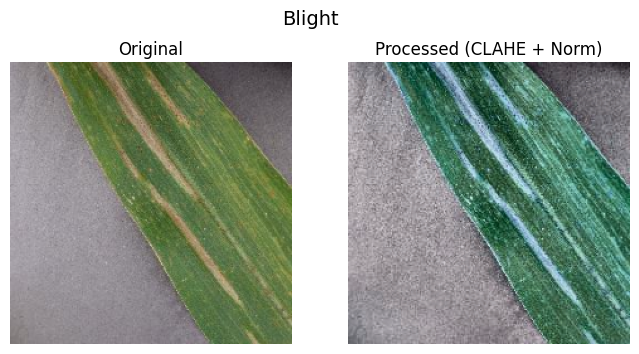

In [53]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random   # নতুন যোগ করা হয়েছে

# ✅ ইনপুট এবং আউটপুট ফোল্ডার
input_folder = dest_path
output_folder = 'blight_dataset_processed'

# ✅ টার্গেট সাইজ
target_size = (224, 224)

# ✅ CLAHE সেটআপ
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# ✅ Image preprocessing ফাংশন
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    img_resized = cv2.resize(img, target_size)

    # CLAHE প্রয়োগ
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Normalization
    img_normalized = img_clahe.astype('float32') / 255.0

    return img_resized, img_normalized

# ✅ Image Preview ফাংশন
def show_images(original, processed, title=''):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(processed)
    plt.title('Processed (CLAHE + Norm)')
    plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# ✅ 'blight' ক্লাস থেকে random একটি ছবি নেওয়া
all_classes = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
blight_classes = [c for c in all_classes if 'blight' in c.lower()]

if not blight_classes:
    print("❌ 'blight' নামের কোনো ক্লাস পাওয়া যায়নি!")
    print("ℹ️ Available classes:", all_classes)
else:
    sample_class = blight_classes[0]   # প্রথম blight ক্লাসটি নিলাম
    class_dir = os.path.join(input_folder, sample_class)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    if not images:
        print(f"❌ '{sample_class}' ক্লাসে কোনো ছবি পাওয়া যায়নি!")
    else:
        sample_img = random.choice(images)   # 🎲 random একটি ইমেজ বাছাই
        img_path = os.path.join(class_dir, sample_img)

        original_img, processed_img = preprocess_image(img_path)
        if original_img is None:
            print("❌ ছবিটি পড়া যায়নি:", img_path)
        else:
            print(f"📌 Selected Image: {sample_img}")
            show_images(original_img, processed_img, title=sample_class)


In [54]:
# ✅ ব্যাচ প্রিপ্রসেসিং + সেভ শুরু
for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    save_class_path = os.path.join(output_folder, class_name)
    os.makedirs(save_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_class_path, img_name)

        original_img, processed_img = preprocess_image(img_path)
        if processed_img is not None:
            # [0,1] → [0,255] → uint8 → BGR
            processed_img_uint8 = (processed_img * 255).astype('uint8')
            cv2.imwrite(save_path, processed_img_uint8)

In [58]:
classwise_hsv_ranges = {
    'Blight':         ([0, 0, 0], [180, 255, 255]),
    'Gray_Leaf_Spot': ([0, 0, 0], [180, 255, 255]),
    'Common_Rust':    ([0, 0, 0], [180, 255, 255]),
    'Healthy':        ([0, 0, 0], [180, 255, 255])
}


In [60]:
def smart_leaf_crop(img_path, class_name, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # ✅ ক্লাস অনুযায়ী HSV রেঞ্জ ব্যবহার করো
    lower_val, upper_val = classwise_hsv_ranges.get(class_name, ([25,40,40], [95,255,255]))
    lower_green = np.array(lower_val)
    upper_green = np.array(upper_val)

    mask = cv2.inRange(hsv, lower_green, upper_green)

    # ✅ কনট্যুর খুঁজে বড় পাতাটি বের করা
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img, None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]

    # ✅ রিসাইজ
    resized = cv2.resize(cropped, target_size)

    # ✅ CLAHE + Normalize
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    processed = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    normalized = processed.astype('float32') / 255.0

    return img, normalized

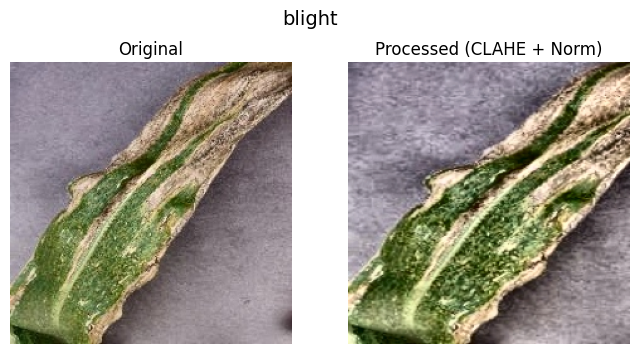

In [63]:
class_name = 'blight'
test_image_path = f'/content/blight_dataset_processed/Blight/Corn_Blight (1002).JPG'
original_img, processed_img = smart_leaf_crop(test_image_path, class_name)
if processed_img is not None:
    show_images(original_img, processed_img, title=class_name)
else:
    print("Leaf not detected in the image.")


In [66]:
import os
from tqdm import tqdm

# ✅ ইনপুট ও আউটপুট ফোল্ডার
input_root = '/content/dataset/dataset'
output_root = '/content/Maize'  # এখানে সেভ হবে

# ✅ সব ক্লাসের উপর লুপ চালাও
for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    # ✅ সেভ ফোল্ডার বানাও
    save_folder = os.path.join(output_root, class_name)
    os.makedirs(save_folder, exist_ok=True)

    # ✅ প্রতিটি ছবির উপর কাজ করো
    for img_name in tqdm(os.listdir(class_path), desc=f'Processing {class_name}'):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_folder, img_name)

        try:
            original_img, processed_img = smart_leaf_crop(img_path, class_name)
            if processed_img is not None:
                # [0–1] scale → [0–255] uint8 এ রূপান্তর
                img_uint8 = (processed_img * 255).astype('uint8')
                img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
                cv2.imwrite(save_path, img_bgr)
        except Exception as e:
            print(f"Failed on {img_path}: {e}")


Processing Healthy: 100%|██████████| 1162/1162 [00:05<00:00, 224.20it/s]


In [67]:
import shutil

input_folder = '/content/dataset'  # তোমার প্রসেসড ছবির মূল ফোল্ডার
zip_path = '/content/Maize_Preprocessed.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', input_folder)
print("✅ Zipping done!")


✅ Zipping done!


In [68]:
# ✅ গন্তব্য ডিরেক্টরি (Drive-এ যেখানে রাখতে চাও)
drive_folder = '/content/drive/MyDrive/Research/Dataset/Preproceessed/maize'

# গন্তব্য ফোল্ডার যদি না থাকে, তৈরি করো
os.makedirs(drive_folder, exist_ok=True)

# ✅ কপি করো
shutil.copy(zip_path, os.path.join(drive_folder, 'Maize_Preprocessed.zip'))
print(f"✅ Uploaded to Google Drive: {drive_folder}")

✅ Uploaded to Google Drive: /content/drive/MyDrive/Research/Dataset/Preproceessed/maize
